# AutoMM Detection - Quick Start on a Tiny COCO Format Dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/autogluon/blob/master/docs/tutorials/multimodal/object_detection/quick_start/quick_start_coco.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/autogluon/blob/master/docs/tutorials/multimodal/object_detection/quick_start/quick_start_coco.ipynb)



In this section, our goal is to fast finetune a pretrained model on a small dataset in COCO format, 
and evaluate on its test set. Both training and test sets are in COCO format.
See [Convert Data to COCO Format](../data_preparation/convert_data_to_coco_format.ipynb) for how to convert other datasets to COCO format.

## Setting up the imports
To start, let's import MultiModalPredictor:

In [ ]:
# !pip install autogluon.multimodal

Make sure `mmcv` and `mmdet` are installed:

In [ ]:
# !mim install "mmcv==2.1.0"
# !pip install "mmdet==3.2.0"

In [1]:
from autogluon.multimodal import MultiModalPredictor

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


And also import some other packages that will be used in this tutorial:

In [2]:
import os
import time

from autogluon.core.utils.loaders import load_zip

## Downloading Data
We have the sample dataset ready in the cloud. Let's download it:

In [3]:
zip_file = "https://automl-mm-bench.s3.amazonaws.com/object_detection_dataset/tiny_motorbike_coco.zip"
download_dir = "./tiny_motorbike_coco"

load_zip.unzip(zip_file, unzip_dir=download_dir)
data_dir = os.path.join(download_dir, "tiny_motorbike")
train_path = os.path.join(data_dir, "Annotations", "trainval_cocoformat.json")
test_path = os.path.join(data_dir, "Annotations", "test_cocoformat.json")

100%|██████████| 21.8M/21.8M [00:13<00:00, 1.65MiB/s]


While using COCO format dataset, the input is the json annotation file of the dataset split.
In this example, `trainval_cocoformat.json` is the annotation file of the train-and-validate split,
and `test_cocoformat.json` is the annotation file of the test split.

## Creating the MultiModalPredictor
We select the `"medium_quality"` presets, which uses a YOLOX-large model pretrained on COCO dataset. This preset is fast to finetune or inference,
and easy to deploy. We also provide presets `"high_quality"` with a DINO-Resnet50 model and `"best quality"` with a DINO-SwinL model, with much higher performance but also slower and with higher GPU memory usage.

In [4]:
presets = "medium_quality"

We create the MultiModalPredictor with selected presets.
We need to specify the problem_type to `"object_detection"`,
and also provide a `sample_data_path` for the predictor to infer the catgories of the dataset.
Here we provide the `train_path`, and it also works using any other split of this dataset.
And we also provide a `path` to save the predictor. 
It will be saved to a automatically generated directory with timestamp under `AutogluonModels` if `path` is not specified.

In [5]:
# Init predictor
import uuid

model_path = f"./tmp/{uuid.uuid4().hex}-quick_start_tutorial_temp_save"

predictor = MultiModalPredictor(
    problem_type="object_detection",
    sample_data_path=train_path,
    presets=presets,
    path=model_path,
)

## Finetuning the Model

Learning rate, number of epochs, and batch_size are included in the presets, and thus no need to specify.
Note that we use a two-stage learning rate option during finetuning by default,
and the model head will have 100x learning rate.
Using a two-stage learning rate with high learning rate only on head layers makes
the model converge faster during finetuning. It usually gives better performance as well,
especially on small datasets with hundreds or thousands of images.
We also compute the time of the fit process here for better understanding the speed.
We run it on a g4.2xlarge EC2 machine on AWS,
and part of the command outputs are shown below:

In [6]:
start = time.time()
predictor.fit(train_path)  # Fit
train_end = time.time()

=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.2.0: Wed Nov 15 21:54:10 PST 2023; root:xnu-10002.61.3~2/RELEASE_X86_64
CPU Count:          16
Pytorch Version:    2.0.0.post104
CUDA Version:       CUDA is not available
Memory Avail:       42.53 GB / 64.00 GB (66.5%)
Disk Space Avail:   WARNING, an exception (FileNotFoundError) occurred while attempting to get available disk space. Consider opening a GitHub Issue.
Using default root folder: ./tiny_motorbike_coco/tiny_motorbike/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!



AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save
    ```

Global seed set to 0


GPU Count: 0                                        
GPU Count to be Used: 0



Loads checkpoint by local backend from path: yolox_l_8x8_300e_coco_20211126_140236-d3bd2b23.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 256, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.0.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([10]).
size mismatch for bbox_head.multi_level_conv_cls.1.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([10, 256, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([10]).
size mismatch for bbox_head.multi_level_conv_cls.2.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the sha

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/autogluon/multimodal/utils/environment.py:131: UserWarning: Only CPU is detected in the instance. This may result in slow speed for MultiModalPredictor. Consider using an instance with GPU support.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | model             | MMDetAutoModelForObjectDetection | 54.2 M
1 | validation_metric | MeanAveragePrecision             | 0     
-----------------------------------------------------------------------
54.2 M    Trainable params
0         Non-trainable params
54.2 M    Total params
216.620   Total estimated model param

Sanity Checking: 0it [00:00, ?it/s]

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)
/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:01<00:01,  1.47s/it]

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0:   0%|          | 0/68 [00:00<?, ?it/s]                            

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)
/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)


Epoch 2: 100%|██████████| 68/68 [05:20<00:00,  4.72s/it]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  18%|█▊        | 3/17 [00:05<00:24,  1.78s/it]

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



Epoch 2: 100%|██████████| 68/68 [05:49<00:00,  5.14s/it]                

Epoch 2, global step 6: 'val_map' reached 0.23788 (best 0.23788), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=2-step=6.ckpt' as top 1


Epoch 5: 100%|██████████| 68/68 [05:22<00:00,  4.74s/it]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 68/68 [05:51<00:00,  5.17s/it]                

Epoch 5, global step 12: 'val_map' reached 0.28761 (best 0.28761), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=5-step=12.ckpt' as top 1


Epoch 8: 100%|██████████| 68/68 [05:18<00:00,  4.69s/it]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 68/68 [05:50<00:00,  5.16s/it]                

Epoch 8, global step 18: 'val_map' reached 0.36381 (best 0.36381), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=8-step=18.ckpt' as top 1


Epoch 11: 100%|██████████| 68/68 [05:35<00:00,  4.93s/it]
Validation: 0it [00:00, ?it/s]
Epoch 11: 100%|██████████| 68/68 [06:07<00:00,  5.40s/it]               

Epoch 11, global step 24: 'val_map' reached 0.39281 (best 0.39281), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=11-step=24.ckpt' as top 1


Epoch 14: 100%|██████████| 68/68 [05:03<00:00,  4.46s/it]
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████| 68/68 [05:32<00:00,  4.89s/it]               

Epoch 14, global step 30: 'val_map' reached 0.40540 (best 0.40540), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=14-step=30.ckpt' as top 1


Epoch 17: 100%|██████████| 68/68 [05:49<00:00,  5.14s/it]
Validation: 0it [00:00, ?it/s]
Epoch 17: 100%|██████████| 68/68 [06:15<00:00,  5.53s/it]               

Epoch 17, global step 36: 'val_map' reached 0.41936 (best 0.41936), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=17-step=36.ckpt' as top 1


Epoch 20: 100%|██████████| 68/68 [04:22<00:00,  3.86s/it]
Validation: 0it [00:00, ?it/s]
Epoch 20: 100%|██████████| 68/68 [04:44<00:00,  4.19s/it]               

Epoch 20, global step 42: 'val_map' reached 0.42612 (best 0.42612), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=20-step=42.ckpt' as top 1


Epoch 23: 100%|██████████| 68/68 [04:26<00:00,  3.92s/it]
Validation: 0it [00:00, ?it/s]
Epoch 23: 100%|██████████| 68/68 [04:50<00:00,  4.28s/it]               

Epoch 23, global step 48: 'val_map' reached 0.43275 (best 0.43275), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=23-step=48.ckpt' as top 1


Epoch 26: 100%|██████████| 68/68 [04:31<00:00,  3.99s/it]
Validation: 0it [00:00, ?it/s]
Epoch 26: 100%|██████████| 68/68 [04:54<00:00,  4.34s/it]               

Epoch 26, global step 54: 'val_map' reached 0.43312 (best 0.43312), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=26-step=54.ckpt' as top 1


Epoch 29: 100%|██████████| 68/68 [04:26<00:00,  3.92s/it]
Validation: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████| 68/68 [04:49<00:00,  4.26s/it]               

Epoch 29, global step 60: 'val_map' was not in top 1


Epoch 32: 100%|██████████| 68/68 [04:27<00:00,  3.93s/it]
Validation: 0it [00:00, ?it/s]
Epoch 32: 100%|██████████| 68/68 [04:49<00:00,  4.25s/it]               

Epoch 32, global step 66: 'val_map' reached 0.43421 (best 0.43421), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=32-step=66.ckpt' as top 1


Epoch 35: 100%|██████████| 68/68 [05:20<00:00,  4.71s/it]
Validation: 0it [00:00, ?it/s]
Epoch 35: 100%|██████████| 68/68 [05:49<00:00,  5.14s/it]               

Epoch 35, global step 72: 'val_map' was not in top 1


Epoch 38: 100%|██████████| 68/68 [04:40<00:00,  4.12s/it]
Validation: 0it [00:00, ?it/s]
Epoch 38: 100%|██████████| 68/68 [05:04<00:00,  4.48s/it]               

Epoch 38, global step 78: 'val_map' reached 0.43447 (best 0.43447), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=38-step=78.ckpt' as top 1


Epoch 41: 100%|██████████| 68/68 [04:33<00:00,  4.02s/it]
Validation: 0it [00:00, ?it/s]
Epoch 41: 100%|██████████| 68/68 [04:55<00:00,  4.34s/it]               

Epoch 41, global step 84: 'val_map' reached 0.43743 (best 0.43743), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=41-step=84.ckpt' as top 1


Epoch 44: 100%|██████████| 68/68 [04:25<00:00,  3.90s/it]
Validation: 0it [00:00, ?it/s]
Epoch 44: 100%|██████████| 68/68 [04:48<00:00,  4.25s/it]               

Epoch 44, global step 90: 'val_map' reached 0.44095 (best 0.44095), saving model to '/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/epoch=44-step=90.ckpt' as top 1


Epoch 47: 100%|██████████| 68/68 [04:26<00:00,  3.93s/it]
Validation: 0it [00:00, ?it/s]
Epoch 47: 100%|██████████| 68/68 [04:49<00:00,  4.26s/it]               

Epoch 47, global step 96: 'val_map' was not in top 1


Epoch 49: 100%|██████████| 68/68 [05:50<00:00,  5.15s/it]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 68/68 [05:50<00:00,  5.15s/it]


AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




Notice that at the end of each progress bar, if the checkpoint at current stage is saved,
it prints the model's save path.
In this example, it's `./quick_start_tutorial_temp_save`.

Print out the time and we can see that it's fast!

In [7]:
print("This finetuning takes %.2f seconds." % (train_end - start))

This finetuning takes 15263.27 seconds.


## Evaluation

To evaluate the model we just trained, run following code.

And the evaluation results are shown in command line output. 
The first line is mAP in COCO standard, and the second line is mAP in VOC standard (or mAP50). 
For more details about these metrics, see [COCO's evaluation guideline](https://cocodataset.org/#detection-eval).
Note that for presenting a fast finetuning we use presets "medium_quality", 
you could get better result on this dataset by simply using "high_quality" or "best_quality" presets, 
or customize your own model and hyperparameter settings: [Customization](../../advanced_topics/customization.ipynb), and some other examples at [Fast Fine-tune Coco](../finetune/detection_fast_finetune_coco) or [High Performance Fine-tune Coco](../finetune/detection_high_performance_finetune_coco).

In [8]:
predictor.evaluate(test_path)
eval_end = time.time()

Using default root folder: ./tiny_motorbike_coco/tiny_motorbike/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Predicting: 0it [00:00, ?it/s]

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)
/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)


Predicting DataLoader 0: 100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


A new predictor save path is created. This is to prevent you to overwrite previous predictor saved here. You could check current save path at predictor._save_path. If you still want to use this path, set resume=True
No path specified. Models will be saved in: "AutogluonModels/ag-20231228_115453"


saving file at /Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/AutogluonModels/ag-20231228_115453/object_detection_result_cache.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.697
 Average Recall     (AR) @[

Print out the evaluation time:

In [9]:
print("The evaluation takes %.2f seconds." % (eval_end - train_end))

The evaluation takes 56.62 seconds.


We can load a new predictor with previous save_path,
and we can also reset the number of GPUs to use if not all the devices are available:

In [10]:
# Load and reset num_gpus
new_predictor = MultiModalPredictor.load(model_path)
new_predictor.set_num_gpus(1)

Load pretrained checkpoint: /Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/tmp/f9f49e23ced6420285658b64536de0a5-quick_start_tutorial_temp_save/model.ckpt


Evaluating the new predictor gives us exactly the same result:

In [11]:
# Evaluate new predictor
new_predictor.evaluate(test_path)

Using default root folder: ./tiny_motorbike_coco/tiny_motorbike/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/autogluon/multimodal/utils/environment.py:62: UserWarning: Using the detected GPU number 0, smaller than the GPU number 1 in the config.
  warnings.warn(


Predicting: 0it [00:00, ?it/s]

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)
/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)


Predicting DataLoader 0: 100%|██████████| 25/25 [00:37<00:00,  1.52s/it]


A new predictor save path is created. This is to prevent you to overwrite previous predictor saved here. You could check current save path at predictor._save_path. If you still want to use this path, set resume=True
No path specified. Models will be saved in: "AutogluonModels/ag-20231228_115552"


saving file at /Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/AutogluonModels/ag-20231228_115552/object_detection_result_cache.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.697
 Average Recall     (AR) @[

{'map': 0.35717350845148055,
 'mean_average_precision': 0.35717350845148055,
 'map_50': 0.5138282079016491,
 'map_75': 0.3872136269895147,
 'map_small': 0.30197115509870315,
 'map_medium': 0.45571738066745393,
 'map_large': 0.6974798727256425,
 'mar_1': 0.23540051679586557,
 'mar_10': 0.42287714352830624,
 'mar_100': 0.4455569649988254,
 'mar_small': 0.37520833333333337,
 'mar_medium': 0.5442857142857143,
 'mar_large': 0.8095996401259558}

For how to set the hyperparameters and finetune the model with higher performance, 
see [AutoMM Detection - High Performance Finetune on COCO Format Dataset](../finetune/detection_high_performance_finetune_coco.ipynb).

## Inference
Now that we have gone through the model setup, finetuning, and evaluation, this section details the inference. 
Specifically, we layout the steps for using the model to make predictions and visualize the results.

To run inference on the entire test set, perform:

In [12]:
pred = predictor.predict(test_path)
print(pred)

Using default root folder: ./tiny_motorbike_coco/tiny_motorbike/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Predicting: 0it [00:00, ?it/s]

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)
/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)


Predicting DataLoader 0: 100%|██████████| 25/25 [00:46<00:00,  1.88s/it]
                                                image  \
0   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
1   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
2   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
3   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
4   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
5   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
6   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
7   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
8   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
9   ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
10  ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
11  ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
12  ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
13  ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
14  ./tiny_motorbike_coco/tiny_motorbike/Annotatio...   
15  ./tiny_moto

The output `pred` is a `pandas` `DataFrame` that has two columns, `image` and `bboxes`.

In `image`, each row contains the image path

In `bboxes`, each row is a list of dictionaries, each one representing a bounding box: `{"class": <predicted_class_name>, "bbox": [x1, y1, x2, y2], "score": <confidence_score>}`

Note that, by default, the `predictor.predict` does not save the detection results into a file.

To run inference and save results, run the following:

In [13]:
pred = predictor.predict(test_path, save_results=True)

Using default root folder: ./tiny_motorbike_coco/tiny_motorbike/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Predicting: 0it [00:00, ?it/s]

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)
/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)


Predicting DataLoader 0: 100%|██████████| 25/25 [00:39<00:00,  1.57s/it]


A new predictor save path is created. This is to prevent you to overwrite previous predictor saved here. You could check current save path at predictor._save_path. If you still want to use this path, set resume=True
No path specified. Models will be saved in: "AutogluonModels/ag-20231228_115758"
Saved detection results to /Users/elnath/004_deep_learning/AutoGloun-Official/v1_0_0/docs/tutorials/multimodal/object_detection/quick_start/AutogluonModels/ag-20231228_115758/result.txt


Here, we save `pred` into a `.txt` file, which exactly follows the same layout as in `pred`.
You can use a predictor initialized in any way (i.e. finetuned predictor, predictor with pretrained model, etc.).

## Visualizing Results
To run visualizations, ensure that you have `opencv` installed. If you haven't already, install `opencv` by running

In [14]:
# !pip install opencv-python

To visualize the detection bounding boxes, run the following:

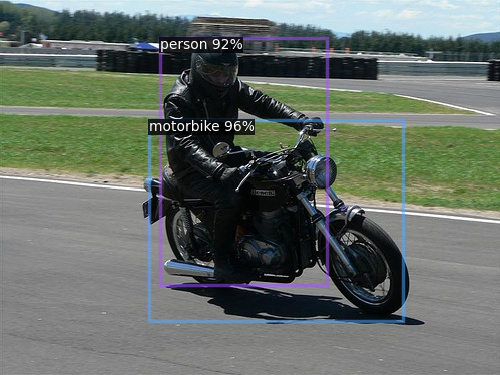

In [15]:
from autogluon.multimodal.utils import ObjectDetectionVisualizer

conf_threshold = 0.4  # Specify a confidence threshold to filter out unwanted boxes
image_result = pred.iloc[30]

img_path = image_result.image  # Select an image to visualize

visualizer = ObjectDetectionVisualizer(img_path)  # Initialize the Visualizer
out = visualizer.draw_instance_predictions(image_result, conf_threshold=conf_threshold)  # Draw detections
visualized = out.get_image()  # Get the visualized image

from PIL import Image
from IPython.display import display
img = Image.fromarray(visualized, 'RGB')
display(img)

## Testing on Your Own Data
You can also predict on your own images with various input format. The follow is an example:

Download the example image:

In [16]:
from autogluon.multimodal import download
image_url = "https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/detection/street_small.jpg"
test_image = download(image_url)

Run inference on data in a json file of COCO format (See [Convert Data to COCO Format](../data_preparation/convert_data_to_coco_format.ipynb) for more details about COCO format). Note that since the root is by default the parent folder of the annotation file, here we put the annotation file in a folder:

In [17]:
import json

# create a input file for demo
data = {"images": [{"id": 0, "width": -1, "height": -1, "file_name": test_image}], "categories": []}
os.mkdir("input_data_for_demo")
input_file = "input_data_for_demo/demo_annotation.json"
with open(input_file, "w+") as f:
    json.dump(data, f)

pred_test_image = predictor.predict(input_file)
print(pred_test_image)

Using default root folder: input_data_for_demo/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Predicting: 0it [00:00, ?it/s]

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
                                     image  \
0  input_data_for_demo/../street_small.jpg   

                                              bboxes  
0  [{'class': 'person', 'class_id': 8, 'bbox': [2...  


Run inference on data in a list of image file names:

In [18]:
pred_test_image = predictor.predict([test_image])
print(pred_test_image)

Predicting: 0it [00:00, ?it/s]

/Users/elnath/anaconda3/envs/venv_ag_310/lib/python3.10/site-packages/mmdet/structures/bbox/base_boxes.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699115979449/work/torch/csrc/utils/tensor_new.cpp:248.)
  data = torch.as_tensor(data)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]
              image                                             bboxes
0  street_small.jpg  [{'class': 'person', 'class_id': 8, 'bbox': [2...


## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../../advanced_topics/customization.ipynb).

## Citation

```
@article{DBLP:journals/corr/abs-2107-08430,
  author    = {Zheng Ge and
               Songtao Liu and
               Feng Wang and
               Zeming Li and
               Jian Sun},
  title     = {{YOLOX:} Exceeding {YOLO} Series in 2021},
  journal   = {CoRR},
  volume    = {abs/2107.08430},
  year      = {2021},
  url       = {https://arxiv.org/abs/2107.08430},
  eprinttype = {arXiv},
  eprint    = {2107.08430},
  timestamp = {Tue, 05 Apr 2022 14:09:44 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/abs-2107-08430.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org},
}
```
